<h1 style='font-size: 35px; color: crimson; font-family: Colonna MT; font-weight: 600; text-align: center'>A/B Testing on Marketing Campaigns</h1>

---

<h1 style=' font-weight: 600; font-size: 18px; text-align: left'> Problem Context</h1>

A fashion retail company is preparing to launch new product to their apparel catalog. Nevertheless, the management hasn't decided which one of three marketing campaigns in order to promote their new product. Therefore, they decide to disperse and introduce its new product in random selected outlets to examine which marketing campaigns has the substantial impact on product sales. So the company uses different approach of marketing campaigns for each outlets and new product is evaluated by assessing the weekly sales on this month (4 effective weeks).

<h1 style=' font-weight: 600; font-size: 20px; text-align: left'>1.0. Import Required Libraries</h1>

In [ ]:
# Statistical Analysis and Statistical Modeling
from scipy.stats import shapiro, levene, skew, kurtosis, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats

# Data Manipulation and  Visualization
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import re


pd.set_option('display.max_columns', 70)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("....Libraries Loaded Successfully....")

....Libraries Loaded Successfully....


<h1 style='font-weight: 600; font-size: 18px; text-align: left'>2.0. Import and Preprocessing Dataset</h1>

In [ ]:
filepath = "Datasets/Marketing Campaign Data 01.csv"
df = pd.read_csv(filepath)
display(df)

,OutletID,Market Size,Age of Outlets,Campaigns,Week,Sales ('000')
0,1,Medium,4,Control Group,1,33.73
1,1,Medium,4,Control Group,2,35.67
2,1,Medium,4,Control Group,3,29.03
3,1,Medium,4,Control Group,4,39.25
4,2,Medium,5,Product Discount,1,27.81
...,...,...,...,...,...,...
543,919,Large,2,Loyalty Bonus,4,64.34
544,920,Large,14,Product Discount,1,50.20
545,920,Large,14,Product Discount,2,45.75
546,920,Large,14,Product Discount,3,44.29


<h1 style=' font-weight: 600; font-size: 18px; text-align: left'>3.0. Exploratory Data Analysis</h1>

Now, let’s move into Exploratory Data Analysis (EDA) — an important step where we take a closer look at our dataset to understand its structure, identify patterns, detect anomalies, and get a sense of the overall distribution of plant parameters. This will help us gain valuable insights and guide the direction of our statistical tests and interpretations.


<h3 style='font-size: 15px; font-weight: 600'>3.1: Dataset Informartion Overviews</h3>


In [ ]:
df.shape

(548, 6)

In [ ]:
for column in df.columns.tolist(): print(f"{'-'*15} {column}")

--------------- OutletID
--------------- Market Size
--------------- Age of Outlets
--------------- Campaigns
--------------- Week
--------------- Sales ('000')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OutletID        548 non-null    int64  
 1   Market Size     548 non-null    object 
 2   Age of Outlets  548 non-null    int64  
 3   Campaigns       548 non-null    object 
 4   Week            548 non-null    int64  
 5   Sales ('000')   548 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 25.8+ KB


<h4 style='font-size: 15px; font-weight: 600'>3.1.1: Columns Summary</h4>

In [ ]:
def column_summary(df):
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df


summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,OutletID,int64,0,548,137,"{1: 4, 2: 4, 3: 4, 4: 4, 5: 4, 6: 4, 7: 4, 8: ..."
1,Market Size,object,0,548,3,"{'Medium': 320, 'Large': 168, 'Small': 60}"
2,Age of Outlets,int64,0,548,25,"{1: 80, 4: 44, 5: 44, 8: 40, 7: 40, 6: 36, 3: ..."
3,Campaigns,object,0,548,3,"{'Control Group': 188, 'Product Discount': 188..."
4,Week,int64,0,548,4,"{1: 137, 2: 137, 3: 137, 4: 137}"
5,Sales ('000'),float64,0,548,517,"{47.22: 3, 51.09: 3, 48.18: 2, 46.03: 2, 37.32..."


<h4 style='font-size: 15px; font-weight: 600'>3.1.2: Checking Missing Values</h4>

Checking for missing values is a crucial step in data analysis to assess the completeness and reliability of the dataset. This involves identifying any columns with null or empty entries, which may affect the accuracy of statistical models.

In [ ]:
def Missig_values_info(df):
    isna_df = df.isna().sum().reset_index(name='Missing Values Counts')
    isna_df['Proportions (%)'] = isna_df['Missing Values Counts']/len(df)*100
    return isna_df

isna_df = Missig_values_info(df)
isna_df

,index,Missing Values Counts,Proportions (%)
0,OutletID,0,0.00
1,Market Size,0,0.00
2,Age of Outlets,0,0.00
3,Campaigns,0,0.00
4,Week,0,0.00
5,Sales ('000'),0,0.00


In [ ]:

<h4 style='font-size: 15px; font-weight: 600'>3.1.3: Exploring Invalid Entries Dtypes</h4>


Exploring invalid entries in data types involves identifying values that do not match the expected format or category within each column. This includes detecting inconsistencies such as numerical values in categorical fields, incorrect data formats, or unexpected symbols and typos. Invalid entries can lead to errors in analysis and model performance, making it essential to standardize data types and correct anomalies.

In [ ]:
def simplify_dtype(dtype):
    if dtype in (int, float, np.number): return 'Numeric'
    elif np.issubdtype(dtype, np.datetime64): return 'Datetime'
    elif dtype == str: return 'String'
    elif dtype == type(None): return 'Missing'
    else: return 'Other'

def analyze_column_dtypes(df):
    all_dtypes = {'Numeric', 'Datetime', 'String', 'Missing', 'Other'}
    results = pd.DataFrame(index=df.columns, columns=list(all_dtypes), dtype=object).fillna('-')

    for column in df.columns:
        dtypes = df[column].apply(lambda x: simplify_dtype(type(x))).value_counts()
        percentages = (dtypes / len(df)) * 100
        for dtype, percent in percentages.items():
            if percent > 0:
                results.at[column, dtype] = f'{percent:.2f}%'  # Add % sign and format to 2 decimal places
            else:
                results.at[column, dtype] = '-'  # Add dash for 0%
    return results

results = analyze_column_dtypes(df)
display(results)

,String,Numeric,Datetime,Missing,Other
OutletID,-,100.00%,-,-,-
Market Size,100.00%,-,-,-,-
Age of Outlets,-,100.00%,-,-,-
Campaigns,100.00%,-,-,-,-
Week,-,100.00%,-,-,-
Sales ('000'),-,100.00%,-,-,-


<h2 style='font-size: 17px;  font-weight: 600'>3.2: Detection and Handling Outliers</h2>

An outlier is a data point that significantly deviates from the rest of the dataset, appearing as an unusually high or low value. Outliers may arise from errors, data entry mistakes, or natural variations, and can distort statistical analysis and machine learning models. To maintain data integrity, outliers should be detected using methods like Z-scores, IQR, or visual tools (e.g., box plots), and then handled appropriately.

<h4 style='font-size: 15px;  font-weight: 600'>3.2.1: Visualize Outliers Using Boxplots</h4>

To gain a more visual and intuitive understanding of how outliers are distributed, we can use **boxplots**. Boxplots not only show the spread and center of the data but also clearly highlight outliers as individual points outside the whiskers, making it easy to see which variables and groups have more extreme values.

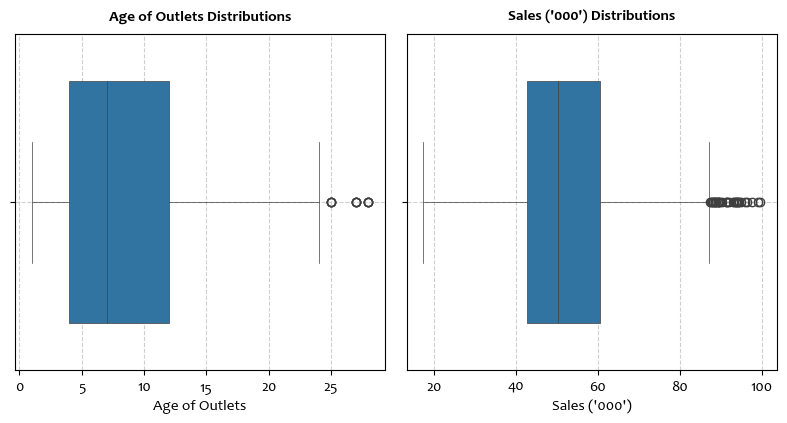

In [ ]:
def plot_boxplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 2)

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, column in enumerate(Metrics):
        sns.boxplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], gap=0.1, linewidth=0.5)
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')

        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
        if group_col: axes[idx].legend(frameon=False)


    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Metrics = ['Age of Outlets','Sales (\'000\')']
plot_boxplot(df, Metrics)

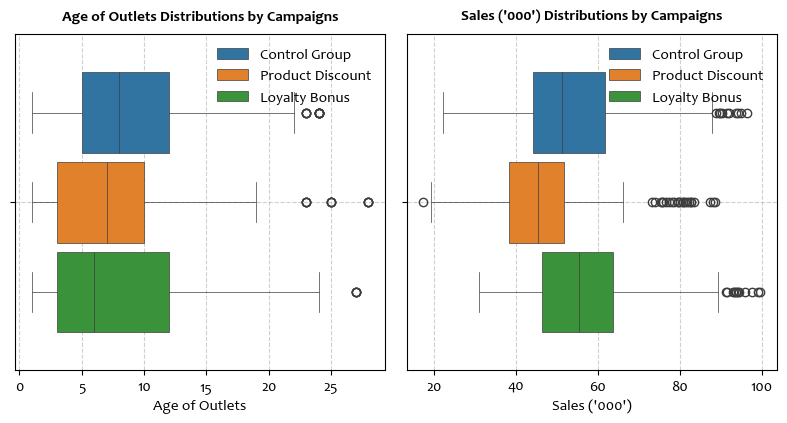

In [ ]:
Metrics = ['Age of Outlets','Sales (\'000\')']
plot_boxplot(df, Metrics, group_col='Campaigns')

<h4 style='font-size: 15px;  font-weight: 600'>3.2.2: Explore Outlier Anomalies Using the IQR Method</h4>

Now, let’s explore outliers in our data using the Interquartile Range (IQR) method. This approach helps us identify extreme values by checking which data points fall far below or above the typical range for each variable. By detecting these anomalies, both overall and within groups, we can better understand the data’s variability and decide if any values need closer attention or cleaning.

In [ ]:
def detect_outliers_overall(df):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    outlier_counts = {}

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        outlier_counts[col] = count

    total_obs = df.shape[0]
    result = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
    result.loc['Total Observations'] = [total_obs]

    return result.astype(int)

overall_outliers = detect_outliers_overall(df)
display(overall_outliers)

,Outlier Count
OutletID,0
Age of Outlets,12
Week,0
Sales ('000'),33
Total Observations,548


The current implementation only returns the counts and proportions of outliers in the dataset, but it doesn’t show which specific groups those outliers belong to. To get a clearer picture, we can create plots that compare outlier distributions across groups, helping us identify which groups are most affected.

In [ ]:
def detect_outliers_by_group(df, group_col):
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    outlier_summary = pd.DataFrame(index=numeric_cols)

    grouped = df.groupby(group_col)
    for group_name, group_data in grouped:
        outlier_counts = []
        for col in numeric_cols:
            Q1 = group_data[col].quantile(0.25)
            Q3 = group_data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            count = group_data[(group_data[col] < lower) | (group_data[col] > upper)].shape[0]
            outlier_counts.append(count)
        outlier_summary[group_name] = outlier_counts

    total_row = df.groupby(group_col).size()
    outlier_summary.loc["Total Observations"] = total_row

    return outlier_summary.fillna(0).astype(int)

outliers_table = detect_outliers_by_group(df, group_col='Campaigns')
display(outliers_table)


,Control Group,Loyalty Bonus,Product Discount
OutletID,0,0,0
Age of Outlets,12,4,12
Week,0,0,0
Sales ('000'),10,12,24
Total Observations,188,172,188


<h2 style='font-size: 18px; font-weight: 600'>3.3: Statistic Description of The Datasets</h2>

Let's take a moment to quickly explore some essential statistics of our dataset. By using the describe() function in pandas, we can generate a summary of key metrics for each numerical column in the dataset. This gives us a bird's-eye view of the data, helping us understand the general distribution and characteristics of the values.

In [ ]:
summary_stats = df.describe().T.reset_index()
summary_stats

,index,count,mean,std,min,25%,50%,75%,max
0,OutletID,548.00,479.66,287.97,1.00,216.00,504.00,708.00,920.00
1,Age of Outlets,548.00,8.50,6.64,1.00,4.00,7.00,12.00,28.00
2,Week,548.00,2.50,1.12,1.00,1.75,2.50,3.25,4.00
3,Sales ('000'),548.00,53.47,16.76,17.34,42.55,50.20,60.48,99.65



<h4 style='font-size: 15px;  font-weight: 600'>3.3.1: Distribution of Continuous variables</h4>


Let’s explore the distribution of **continuous variables** in our dataset by examining key statistics. The ***Mean*** gives us the average value, while the ***Median*** provides the middle value, offering a more robust measure against outliers. The ***Mode*** identifies the most frequent value. ***Standard Deviation*** and ***Variance*** show how much the data deviates from the mean, with larger values indicating greater spread. The ***Range*** reveals the difference between the maximum and minimum values, while ***Skewness*** measures the symmetry of the distribution. Lastly, ***Kurtosis*** tells us about the presence of outliers by analyzing the **"tailedness"** of the distribution. Together, these metrics give us a comprehensive view of how the data is distributed and guide us in identifying any potential issues like skewness or outliers.

In [ ]:
def distribution_statistics(df):
    results = []
    for col in df.select_dtypes(include=[np.number]).columns:
        mean = df[col].mean()
        median = df[col].median()
        mode = df[col].mode().iloc[0] if not df[col].mode().empty else np.nan
        std_dev = df[col].std()
        variance = df[col].var()
        value_range = df[col].max() - df[col].min()
        skewness_val = skew(df[col], nan_policy='omit')  # Skewness
        kurtosis_val = kurtosis(df[col], nan_policy='omit')  # Kurtosis


        results.append({
            'Parameter': col,
            'Mean': mean,
            'Median': median,
            'Mode': mode,
            'Standard Deviation': std_dev,
            'Variance': variance,
            'Range': value_range,
            'Skewness': skewness_val,
            'Kurtosis': kurtosis_val
        })


    result_df = pd.DataFrame(results)
    return result_df

pd.set_option('display.max_columns', 10)
Continuous_variables_distribution = distribution_statistics(df)
display(Continuous_variables_distribution)

,Parameter,Mean,Median,Mode,Standard Deviation,Variance,Range,Skewness,Kurtosis
0,OutletID,479.66,504.00,1.00,287.97,82928.84,919.00,-0.02,-1.16
1,Age of Outlets,8.50,7.00,1.00,6.64,44.07,27.00,1.04,0.36
2,Week,2.50,2.50,1.00,1.12,1.25,3.00,0.00,-1.36
3,Sales ('000'),53.47,50.20,47.22,16.76,280.74,82.31,0.80,0.15


<h4 style='font-size: 15px;  font-weight: 600'>3.3.3: Group-wise Comparatives Analysis of Continuous variables</h4>

Now, let’s turn our attention to comparing the means of variables across different specified groups. By grouping the data based on a categorical feature, we can calculate the mean of each continuous variable within each group. This allows us to identify differences or similarities in average values between groups, offering insights into how the variable behaves under different conditions or categories.


In [ ]:
def summary_stats(df, group):
    Metrics = df.select_dtypes(include=np.number).columns.tolist()
    df_without_location = df.drop(columns=[group])
    grand_mean = df_without_location[Metrics].mean()
    sem = df_without_location[Metrics].sem()
    cv = df_without_location[Metrics].std() / df_without_location[Metrics].mean() * 100
    grouped = df.groupby(group)[Metrics].agg(['mean', 'sem']).reset_index()

    summary_df = pd.DataFrame()
    for col in Metrics:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )

    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()

    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row

    return summary_df

results = summary_stats(df, group='Market Size')
results.T

,0,1,2,3,4,5
Market Size,Large,Medium,Small,Grand Mean,SEM,%CV
OutletID,544.36 ± 27.02,493.55 ± 13.86,224.40 ± 12.85,479.66,12.30,60.04
Age of Outlets,7.14 ± 0.47,8.79 ± 0.36,10.80 ± 1.03,8.50,0.28,78.06
Week,2.50 ± 0.09,2.50 ± 0.06,2.50 ± 0.15,2.50,0.05,44.76
Sales ('000'),70.12 ± 1.32,43.99 ± 0.51,57.41 ± 0.86,53.47,0.72,31.34


In [ ]:
results = summary_stats(df, group='Campaigns')
results.T

,0,1,2,3,4,5
Campaigns,Control Group,Loyalty Bonus,Product Discount,Grand Mean,SEM,%CV
OutletID,453.81 ± 20.02,488.47 ± 22.83,497.45 ± 21.16,479.66,12.30,60.04
Age of Outlets,9.23 ± 0.49,8.28 ± 0.51,7.98 ± 0.48,8.50,0.28,78.06
Week,2.50 ± 0.08,2.50 ± 0.09,2.50 ± 0.08,2.50,0.05,44.76
Sales ('000'),55.36 ± 1.22,58.10 ± 1.26,47.33 ± 1.10,53.47,0.72,31.34


<h4 style='font-size: 15px; font-weight: 600'>4.3.3: Visual Distribution</h4>

To gain more intuitive insights, let's explore the data distribution through visualizations. Visual tools like histograms, box plots, and scatter plots help us easily identify patterns, trends, and outliers in the data. These visuals provide a clear representation of how data is spread across variables, allowing for quicker interpretation and a deeper understanding of the dataset’s structure and relationships.

<span style='font-size: 14px; font-weight: 600'>4.3.3.1:  Histograms:</span> Now, let's visualize the distribution of each continuous variables using histograms. This will help us understand the spread, central tendency, and potential outliers within the overall dataset.


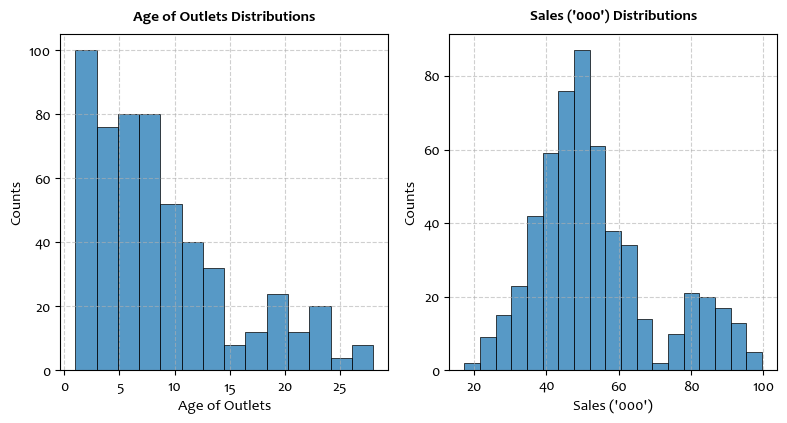

In [ ]:
def hitoplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, column in enumerate(Metrics):
        sns.histplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], linewidth=0.5)
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')

        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].set_ylabel('Counts', fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)

    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Metrics = ['Age of Outlets','Sales (\'000\')']
hitoplot(df, Metrics)

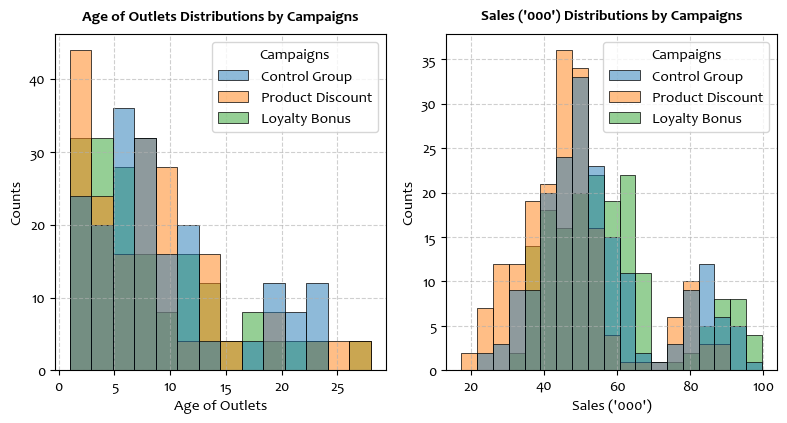

In [ ]:
Metrics = ['Age of Outlets','Sales (\'000\')']
hitoplot(df, Metrics, group_col='Campaigns')

<span style='font-size: 14px; font-weight: 600'>4.3.3.2:  Kernel Density Estimation (KDE) plots:</span> Now, let's visualize the **overall distribution of sales revenue**  using **Kernel Density Estimation (KDE) plots**. These plots provide a smooth curve representing the probability density of each parameter, helping us understand the underlying distribution and identify skewness, peaks, or multimodal patterns in the data.


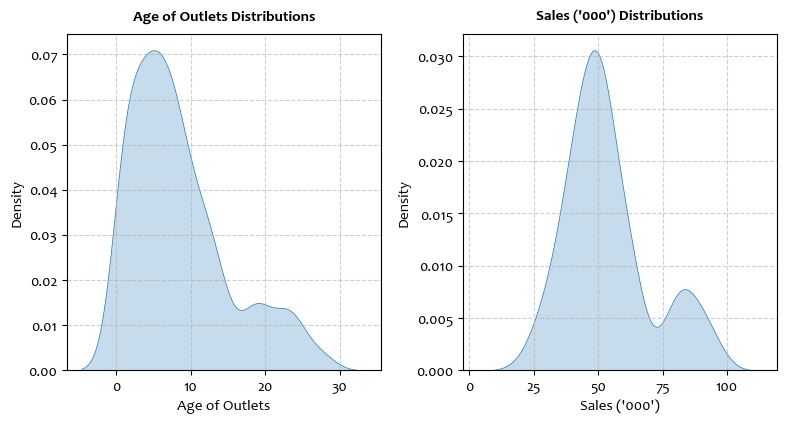

In [ ]:
def plot_kdeplot(df, Metrics, group_col=None):
    num_variables = len(Metrics)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 4)

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4.5* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, column in enumerate(Metrics):
        sns.kdeplot(data=df, x=df[column], fill=True, hue=group_col, ax=axes[idx], linewidth=0.5)
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        if group_col: axes[idx].set_title(f"{column} Distributions by {group_col}", fontsize=11, pad=10, fontweight='bold')

        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].set_ylabel('Density', fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)

    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Metrics = ['Age of Outlets','Sales (\'000\')']
plot_kdeplot(df, Metrics)

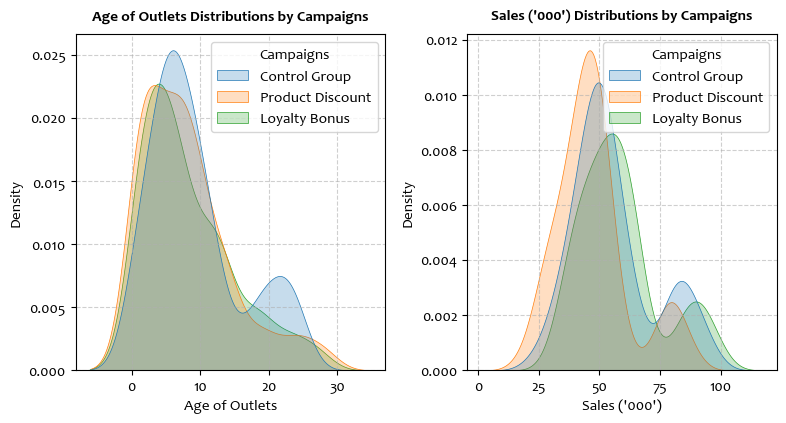

In [ ]:
Metrics = ['Age of Outlets','Sales (\'000\')']
plot_kdeplot(df, Metrics, group_col='Campaigns')

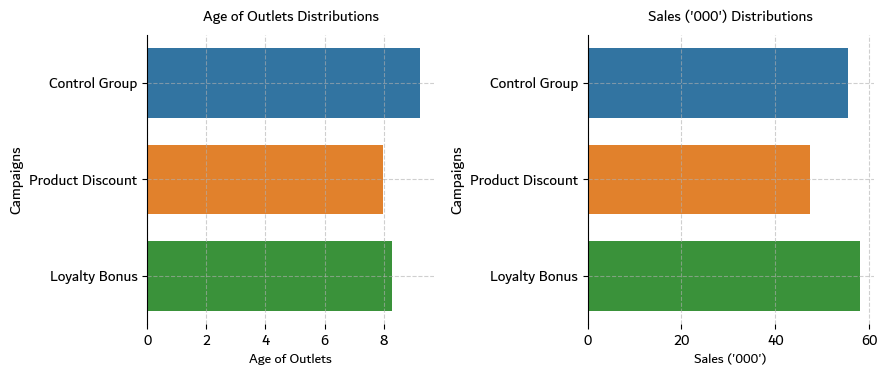

In [ ]:
categorical_variables = ['Age of Outlets', 'Sales (\'000\')']

num_variables = len(categorical_variables)
rows = math.ceil(num_variables / 3)
cols = min(num_variables, 2)

fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 4*rows))
plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
axes = axes.flatten() if num_variables > 1 else [axes]

for idx, column in enumerate(categorical_variables):
    sns.barplot(data=df, x=df[column], y=df['Campaigns'], fill=True, gap=0.1, ax=axes[idx], hue ='Campaigns', linewidth=0.6, errorbar=None)
    sns.despine(ax=axes[idx], right=True, bottom=True)
    axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10)
    axes[idx].set_xlabel(column, fontsize=10)
    axes[idx].grid(linestyle='--', alpha=0.6)
    axes[idx].legend(frameon=False)


for idx in range(num_variables, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<h1 style='font-size: 18px;  font-weight: 600'>4.0: Parametictic Test Assumption Validation</h1>

Before we advance to hypothesis testing it's important to first check whether our variables meet the assumptions required for parametric tests, particularly **normality**. To do this, we’ll use the **Shapiro-Wilk test**, which helps us assess if the distribution of each variable is close to normal. This step ensures the validity of our statistical tests and guides us in choosing the right analysis methods.


<h4 style='font-size: 15px; font-weight: 600'>4.1: Homogeneity of Variance (Homoskedasticity)</h4>

Levene’s Test is a statistical method used to assess homogeneity of variance (homoskedasticity), a key assumption in analyses. It tests whether the variances of different groups are equal, with a p-value greater than 0.05 indicating that the assumption holds. If violated, alternative approaches like Welch's test or data transformation may be necessary to ensure reliable results. This test helps maintain the integrity of statistical analysis by confirming whether t-test is appropriate for a given dataset.

In [ ]:
def Levene_test(df, group_cols, numeric_cols=None):
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        for g in group_cols:
            if g in numeric_cols:
                numeric_cols.remove(g)

    results = []
    for group_col in group_cols:
        for col in numeric_cols:
            grouped_data = [g[col].dropna().values for _, g in df.groupby(group_col)]
            if all(len(g) > 1 for g in grouped_data):  # Ensure each group has enough data
                levene_stat, levene_p = levene(*grouped_data)
                interpretation = '✔' if levene_p > 0.05 else '✖'
                #interpretation = 'Homoscedasticity' if levene_p > 0.05 else 'Heteroscedasticity'

            else:
                levene_stat, levene_p, interpretation = None, None, 'Insufficient data'

            results.append({
                'Group Column': group_col,
                'Variable': col,
                'Test Statistic': levene_stat,
                'P-Value': levene_p,
                'Interpretation': interpretation
            })

    return pd.DataFrame(results)

result_df = Levene_test(df, group_cols=['Campaigns'])
display(result_df)

,Group Column,Variable,Test Statistic,P-Value,Interpretation
0,Campaigns,OutletID,0.79,0.45,✔
1,Campaigns,Age of Outlets,0.07,0.93,✔
2,Campaigns,Week,0.00,1.00,✔
3,Campaigns,Sales ('000'),1.27,0.28,✔


<h4 style='font-size: 15px; font-weight: 600'>4.2: Normal Distribution (Normality Test)</h4>

- In statistical analysis, assessing whether data follows a normal distribution is a critical preliminary step, particularly before applying parametric tests such as ANOVA or t-tests. The assumption of normality underpins the reliability of these tests, as violations can lead to misleading results and incorrect conclusions. To evaluate this, normality tests are employed to determine if the distribution of a dataset aligns closely with a theoretical normal distribution. By verifying this assumption, analysts can decide whether the data is suitable for parametric testing or if alternative methods, such as data transformation or non-parametric tests, are more appropriate.

- In the context of our analysis, we utilize the **Shapiro-Wilk** test to examine normality, especially given its effectiveness with small to moderately sized samples. This test compares the order statistics of the observed data against a normal distribution and yields both a **W statistic** and a **p-value**. A p-value greater than 0.05 indicates that we fail to reject the null hypothesis, suggesting the data is normally distributed. Conversely, a p-value less than **0.05** implies that the data significantly deviates from normality.

- To strengthen this approach, we incorporate the **Central Limit Theorem (CLT)** through **bootstrapping**, where appropriate. By repeatedly sampling from the data and calculating the means of these samples, we approximate a sampling distribution of the mean. When bootstrapping is enabled, the Shapiro-Wilk test is applied to this distribution of sample means rather than the raw data. This helps determine whether the distribution of means — rather than individual observations — approximates normality, aligning with the assumptions of inferential statistics based on the CLT. If bootstrapping is disabled, the Shapiro-Wilk test is applied directly to the original dataset, offering a more traditional view of the data's normality. This dual approach provides flexibility and robustness in assessing the suitability of the data for further statistical analysis.

In [ ]:
def bootstrapping(df, column, num_samples=1000, sample_size=30):
    sample_means = []
    for _ in range(num_samples):
        sample = df[column].dropna().sample(n=sample_size, replace=True)
        sample_means.append(sample.mean())
    return sample_means

def shapiro_wilk_test(df, group_col, numeric_cols=None, use_bootstrap=True, num_samples=1000, sample_size=30):
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        if group_col in numeric_cols:
            numeric_cols.remove(group_col)

    results = []
    for group, group_df in df.groupby(group_col):
        for col in numeric_cols:
            if use_bootstrap:
                data = bootstrapping(group_df, col, num_samples=num_samples, sample_size=sample_size)
            else:
                data = group_df[col].dropna()

            if len(data) >= 3:  # Shapiro requires at least 3 values
                stat, p_value = shapiro(data)
                interpretation = 'Normal' if p_value > 0.05 else 'Not Normal'
            else:
                stat, p_value, interpretation = None, None, 'Insufficient data'

            results.append({
                'Main-Group': group_col,
                'Group': group,
                'Variable': col,
                'Test Statistic': stat,
                'P-Value': p_value,
                'Interpretation': interpretation,
                'Used Bootstrap': use_bootstrap
            })

    results_df = pd.DataFrame(results)
    return results_df

result_df = shapiro_wilk_test(df, group_col='Campaigns', use_bootstrap=True)
display(result_df)

,Main-Group,Group,Variable,Test Statistic,P-Value,Interpretation,Used Bootstrap
0,Campaigns,Control Group,OutletID,1.00,0.48,Normal,True
1,Campaigns,Control Group,Age of Outlets,1.00,0.03,Not Normal,True
2,Campaigns,Control Group,Week,1.00,0.03,Not Normal,True
3,Campaigns,Control Group,Sales ('000'),1.00,0.30,Normal,True
4,Campaigns,Loyalty Bonus,OutletID,1.00,0.14,Normal,True
5,Campaigns,Loyalty Bonus,Age of Outlets,1.00,0.02,Not Normal,True
6,Campaigns,Loyalty Bonus,Week,1.00,0.04,Not Normal,True
7,Campaigns,Loyalty Bonus,Sales ('000'),1.00,0.60,Normal,True
8,Campaigns,Product Discount,OutletID,1.00,0.15,Normal,True
9,Campaigns,Product Discount,Age of Outlets,1.00,0.05,Normal,True


<h4 style='font-size: 15px; font-weight: 600'>4.3: Q-Q plots for Each Group in a Campaigns column</h4>

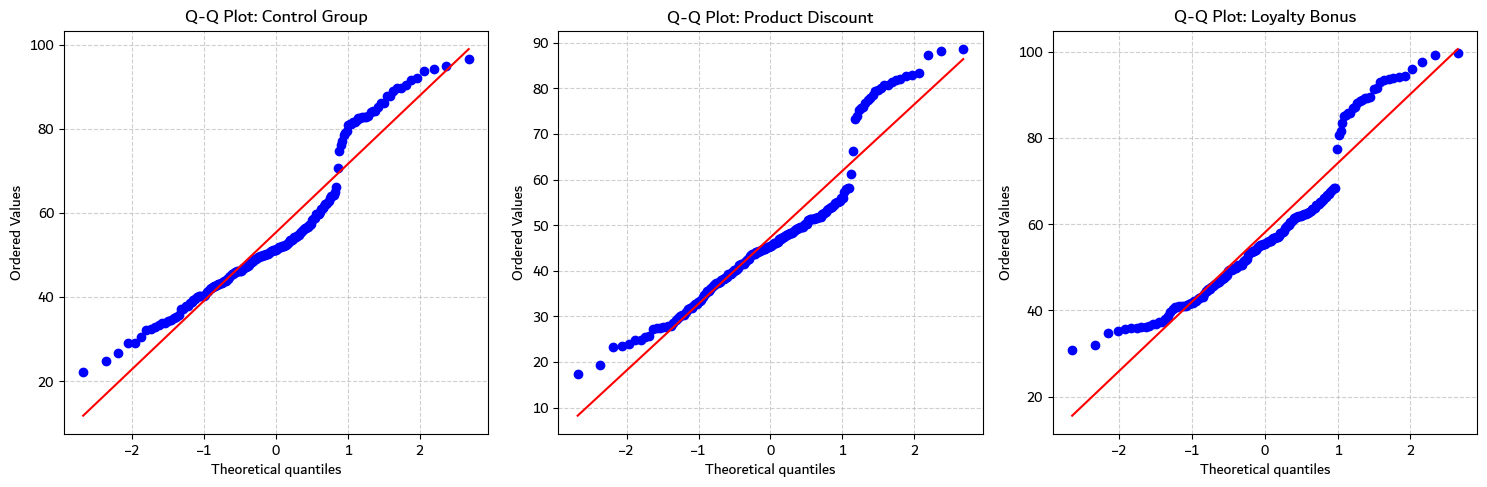

In [ ]:
def qqplot_groups(data, group_col, value_col):
    groups = data[group_col].unique()
    n_groups = len(groups)
    fig, axes = plt.subplots(1, n_groups, figsize=(5 * n_groups, 5))
    if n_groups == 1:
        axes = [axes]

    for ax, group in zip(axes, groups):
        group_data = data[data[group_col] == group][value_col].dropna()
        stats.probplot(group_data, dist="norm", plot=ax)
        ax.set_title(f'Q-Q Plot: {group}')
        ax.grid(linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

qqplot_groups(df, group_col='Campaigns', value_col='Sales (\'000\')')


<h1 style='font-weight: 600; font-size: 20px; text-align: left'>5.0. A/B Testing on Marketing Campaigns | Hypothes Testing (Inferential Statistics)</h1>

<h4 style='font-size: 15px;  font-weight: 600'>5.1: Group-wise Comparatives Analysis of Continuous variables</h4>

Now, let’s turn our attention to comparing the means of variables across different specified groups. By grouping the data based on a categorical feature, we can calculate the mean of each continuous variable within each group. This allows us to identify differences or similarities in average values between groups, offering insights into how the variable behaves under different conditions or categories.


In [ ]:
def summary_stats(df, group):
    Metrics = df.select_dtypes(include=np.number).columns.tolist()
    df_without_location = df.drop(columns=[group])
    grand_mean = df_without_location[Metrics].mean()
    sem = df_without_location[Metrics].sem()
    cv = df_without_location[Metrics].std() / df_without_location[Metrics].mean() * 100
    grouped = df.groupby(group)[Metrics].agg(['mean', 'sem']).reset_index()

    summary_df = pd.DataFrame()
    for col in Metrics:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )

    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()

    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row

    return summary_df

results = summary_stats(df, group='Campaigns')
results.T

,0,1,2,3,4,5
Campaigns,Control Group,Loyalty Bonus,Product Discount,Grand Mean,SEM,%CV
OutletID,453.81 ± 20.02,488.47 ± 22.83,497.45 ± 21.16,479.66,12.30,60.04
Age of Outlets,9.23 ± 0.49,8.28 ± 0.51,7.98 ± 0.48,8.50,0.28,78.06
Week,2.50 ± 0.08,2.50 ± 0.09,2.50 ± 0.08,2.50,0.05,44.76
Sales ('000'),55.36 ± 1.22,58.10 ± 1.26,47.33 ± 1.10,53.47,0.72,31.34


<h4 style='font-weight: 600; font-size: 15px; text-align: left'>5.2. Independent (Two-Sample) T-Test</h4>

In [ ]:
def Independent_ttest(df, group_cols, Variables):
    results = []
    for category in group_cols:
        unique_groups = df[category].unique()
        group_combinations = list(combinations(unique_groups, 2))

        for column in Variables:
            for group1, group2 in group_combinations:
                group1_data = df[df[category] == group1][column]
                group2_data = df[df[category] == group2][column]
                t_stat, p_value = ttest_ind(group1_data, group2_data, equal_var=False)

                results.append({
                    'Group': category,
                    'Parameter': column,
                    'Group 1': group1,
                    'Group 2': group2,
                    'T-Statistic': t_stat,
                    'P-Value': p_value,
                    'Interpretation': 'Significant' if p_value < 0.05 else 'Not Significant'
                })

    results_df = pd.DataFrame(results)
    return results_df

group_col = ['Campaigns', 'Market Size']
Variables = ['Sales (\'000\')']
Results = Independent_ttest(df, group_cols=group_col, Variables=Variables)
display(Results)

,Group,Parameter,Group 1,Group 2,T-Statistic,P-Value,Interpretation
0,Campaigns,Sales ('000'),Control Group,Product Discount,4.88,0.00,Significant
1,Campaigns,Sales ('000'),Control Group,Loyalty Bonus,-1.56,0.12,Not Significant
2,Campaigns,Sales ('000'),Product Discount,Loyalty Bonus,-6.43,0.00,Significant
3,Market Size,Sales ('000'),Medium,Small,-13.50,0.00,Significant
4,Market Size,Sales ('000'),Medium,Large,-18.54,0.00,Significant
5,Market Size,Sales ('000'),Small,Large,-8.10,0.00,Significant


<h4 style='font-size: 15px; font-weight: 600'>5.3: Analysis of Varience (One Way ANOVA)</h4>


A one-way ANOVA (Analysis of Variance) is a statistical test used to determine if there are significant differences between the means of three or more independent groups based on a single factor (or independent variable). It assesses whether the factor has an effect on the dependent variable. If the p-value from the test is less than a specified significance level (usually 0.05), it suggests that at least one group mean is significantly different from the others.

In [ ]:
def rename(text): return re.sub(r'[^a-zA-Z]', "", text)

def One_way_anova(data, Metrics, group_cols):
    results = []
    original_group_cols = group_cols[:]  # Save original names for reporting
    group_cols = [rename(col) for col in group_cols]
    data = data.rename(columns={col: rename(col) for col in data.columns})

    for original_group, group in zip(original_group_cols, group_cols):
        for col in Metrics:
            column_name = rename(col)
            formula = f"{column_name} ~ C({group})"
            model = smf.ols(formula, data=data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)

            for source, row in anova_table.iterrows():
                p_value = row["PR(>F)"]
                interpretation = "Significant" if p_value < 0.05 else "No significant"
                if source == "Residual":
                    interpretation = "-"

                results.append({
                    "Variable": col,
                    #"Factor": original_group,  # Use original name here
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Interpretation": interpretation
                })

    return pd.DataFrame(results)

group_cols = ['Campaigns', 'Market Size']
Metrics = [ 'Sales (\'000\')']
Anova_results = One_way_anova(df, Metrics, group_cols)
Anova_results

,Variable,Source,Sum Sq,df,F-Value,p-Value,Interpretation
0,Sales ('000'),C(Campaigns),11449.17,2.00,21.95,0.00,Significant
1,Sales ('000'),Residual,142114.11,545.00,NaN,NaN,-
2,Sales ('000'),C(MarketSize),76272.95,2.00,268.91,0.00,Significant
3,Sales ('000'),Residual,77290.33,545.00,NaN,NaN,-


<h4 style='font-size: 15px; font-weight: 600'>5.4: Tukey's Honest Significant Difference (THSD)</h4>

Now, let's perform Tukey’s Honest Significant Difference (THSD) test to determine which groups are statistically similar or different. While ANOVA tells us if there is a significant difference among groups, it does not specify which groups differ. Tukey’s HSD helps by comparing all possible group pairs and assigning statistical significance to their differences. This step is crucial in identifying which groups share similarities and which ones are distinct, allowing for a more detailed interpretation of the results.

In [ ]:
def Turkey_results(df, Metrics, group=''):
    results_data = []
    for metric in Metrics:
        turkey_results = pairwise_tukeyhsd(endog=df[metric], groups=df[group], alpha=0.05)
        results_table = turkey_results.summary()

        for i in range(1, len(results_table)):
            row = results_table.data[i]
            results_data.append({
                'Metric': metric,
                'Group1': row[0],
                'Group2': row[1],
                'Mean Difference': row[2],
                'P-Value': row[3],
                'Lower CI': row[4],
                'Upper CI': row[5],
                'Reject Null': row[6]
            })

        result_df = pd.DataFrame(results_data)
    return result_df

Metrics = [ 'Sales (\'000\')']
Turkeyresults = Turkey_results(df, Metrics, group='Campaigns')
pd.set_option("display.float_format", "{:.3f}".format)
Turkeyresults

,Metric,Group1,Group2,Mean Difference,P-Value,Lower CI,Upper CI,Reject Null
0,Sales ('000'),Control Group,Loyalty Bonus,2.735,0.244,-1.270,6.739,False
1,Sales ('000'),Control Group,Product Discount,-8.035,0.000,-11.949,-4.121,True
2,Sales ('000'),Loyalty Bonus,Product Discount,-10.770,0.000,-14.774,-6.765,True


<h4 style='font-size: 15px; font-weight: 600'>5.5: Compact Letter Display (CLD)</h4>

Now, let's compute the **Compact Letter Display (CLD)** across group pairs to summarize the statistical differences between them in a clear and concise table. CLD helps visually represent which groups differ significantly in their means by assigning letters—groups sharing the same letter are not significantly different. This summary makes it easier to interpret multiple pairwise comparisons simultaneously, providing an intuitive overview of group similarities and differences across the dataset.


In [ ]:
from Scripts.compact_letter_display import compact_letter_table

results = compact_letter_table(df, group="Campaigns", savepath=None)
display(results.T)

,Control Group,Loyalty Bonus,Product Discount,p-value
OutletID,453.81 ± 20.02 a,488.47 ± 22.83 a,497.45 ± 21.16 a,0.3028ns
Age of Outlets,9.23 ± 0.49 a,8.28 ± 0.51 a,7.98 ± 0.48 a,0.1615ns
Week,2.50 ± 0.08 a,2.50 ± 0.09 a,2.50 ± 0.08 a,1.0000ns
Sales ('000'),55.36 ± 1.22 b,58.10 ± 1.26 b,47.33 ± 1.10 a,0.0000***


<h4 style='font-size: 15px; font-weight: 600'>5.6: Compact Letter Display (CLD) Visualization</h4>


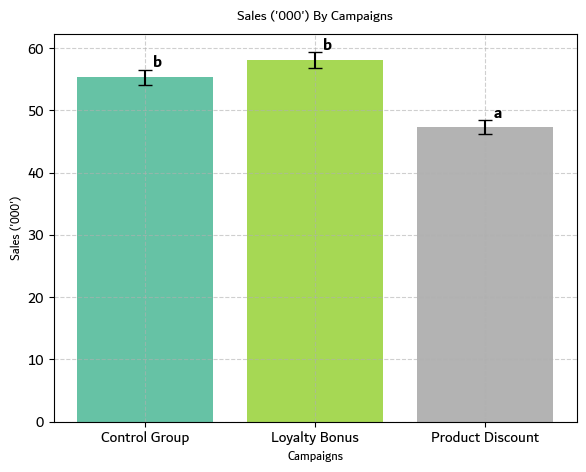

In [ ]:
from Scripts.cld_visualization import cld_plot

Metrics = ['Sales (\'000\')']
cld_plot(df, Metrics, group='Campaigns', savepath=None)

<h1 style='font-weight: 600; font-size: 20px; text-align: left'>6.0. Insights and Key Findings </h1>



- The A/B testing analysis was designed to evaluate the impact of three different marketing strategies—Control (no campaign), Loyalty Bonus, and Product Discount—on overall sales performance. The results show a statistically significant difference in sales between the groups (p-value = 0.0000\*\*\*), meaning the choice of marketing strategy has a meaningful impact on revenue outcomes.

- From the observed sales data, the Loyalty Bonus campaign resulted in the highest average sales (58.10K), slightly higher than the Control Group (55.36K), while the Product Discount campaign recorded the lowest sales (47.33K). According to the Compact Letter Display, both the Control and Loyalty Bonus groups share the same statistical group (denoted by letter **b**), indicating their performance is not significantly different from each other. However, the Product Discount group (denoted by letter **a**) is statistically different and significantly underperforms.

- In business terms, this implies that offering discounts might undermine perceived value, negatively affecting purchasing behavior. Conversely, rewarding existing or repeat customers with loyalty bonuses not only sustains sales but even improves them marginally. Based on this analysis, the business should prioritize loyalty-based campaigns over price-cutting strategies, which may damage brand perception and reduce profitability.
